# Motion Statistical Analysis
Analyzes video clips for frame to frame motion and bins the severity of motion into a histogram.

Iterate over test set and safe duv into dataframe.

- Create test loader
- Load homography estimation model from configs

In [1]:
import os
import cv2
import pandas as pd
import torch
from dotmap import DotMap
from torch.utils.data import DataLoader
from kornia import tensor_to_image, warp_perspective

import lightning_modules
from datasets import VideoDataset
from utils.io import load_yaml, load_pickle, save_pickle, scan2df, natural_keys
from utils.transforms import anyDictListToCompose
from utils.processing import image_edges, four_point_homography_to_matrix
from utils.viz import yt_alpha_blend

# iterate over test set and safe duv into dataframe
server = 'local'
servers = load_yaml('../configs/servers.yml')
server = DotMap(servers[server])

configs = 'next_view.yml'
configs = load_yaml(os.path.join(server.configs.location, configs))

backbone_path = 'deep_image_homography_estimation_backbone/version_2'

# append configs by backbone
backbone_configs = load_yaml(os.path.join(server.logging.location, backbone_path, 'configs.yml'))
df = scan2df(os.path.join(server.logging.location, backbone_path, 'checkpoints'), '.ckpt')
ckpts = sorted(list(df.file), key=natural_keys)
configs['model']['homography_regression'] = {
    'lightning_module': backbone_configs['lightning_module'],
    'model': backbone_configs['model'],
    'path': backbone_path,
    'checkpoint': 'checkpoints/{}'.format(ckpts[-1]),
    'experiment': backbone_configs['experiment']
}

configs = DotMap(configs)

meta_df = pd.read_pickle(os.path.join(server.configs.location, configs.data.meta_df))
test_meta_df = meta_df[meta_df.train == False]
test_video_paths = [os.path.join(server.database.location, row.database, row.file['path'], row.file['name']) for _, row in test_meta_df.iterrows()]
test_pre_transforms = [anyDictListToCompose(row.pre_transforms) for _, row in test_meta_df.iterrows()]
test_aug_transforms = [anyDictListToCompose(row.aug_transforms) for _, row in test_meta_df.iterrows()]

# load video meta data if existing, returns None if none existent
test_metadata = load_pickle(os.path.join(server.configs.location, configs.data.test_metadata))
if test_metadata is not None:
    if len(test_metadata['video_paths']) == 0:
        test_metadata = None

# create video dataset and dataloader
clip_length_in_frames = 2
frame_rate = 5
frames_between_clips = 1
precomputed_metadata = test_metadata
num_workers = 1
pre_transforms = test_pre_transforms
aug_transforms = test_aug_transforms
seeds = True

vid_ds = VideoDataset(
    video_paths=test_video_paths,
    clip_length_in_frames=clip_length_in_frames,
    frames_between_clips=frames_between_clips,
    frame_rate=frame_rate,
    precomputed_metadata=test_metadata,
    num_workers=num_workers,
    pre_transforms=pre_transforms,
    aug_transforms=aug_transforms,
    seeds=seeds
)

# save metadata
if test_metadata is None:
    save_pickle(os.path.join(server.configs.location, configs.data.test_metadata), vid_ds.metadata)

batch_size = 4
drop_last = True

vid_dl = DataLoader(
    vid_ds,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=drop_last
)

# load model
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
print('Running on {}'.format(device))
torch.set_grad_enabled(False)
homography_regression = getattr(lightning_modules, configs.model.homography_regression.lightning_module).load_from_checkpoint(
    checkpoint_path=os.path.join(server.logging.location, configs.model.homography_regression.path, configs.model.homography_regression.checkpoint),
    **configs.model
)
homography_regression.to(device).eval()

# run inference and log duvs with corresponding vid and frame index
log_df = pd.DataFrame(columns=['vid_idx', 'frame_idx', 'duv', 'uv', 'H'])

for batch_idx, batch in enumerate(vid_dl):
    vids, aug_vids, re_sample_frame_rates, frame_rates, vid_idc, frame_idc = batch
    print('\rBatch: {}/{}, BxNxCxHxW: {}, Video/Frame Idices: {}/{}'.format(batch_idx + 1, len(vid_dl), list(vids.shape), list(vid_idc), list(frame_idc)), end='')

    vids = vids.to(device)

    frames_i, frames_ips = vids[:,0], vids[:,1]  # N = 2

    frames_i   = frames_i.view((-1,) + frames_i.shape[-3:])      # BxNxCxHxW -> B*NxCxHxW
    frames_ips = frames_ips.view((-1,) + frames_ips.shape[-3:])  # BxNxCxHxW -> B*NxCxHxW
    duvs = homography_regression(frames_i, frames_ips)

    # duvs = duvs.view()  # no reshape as N = 2
    uvs = image_edges(frames_i)         
    Hs = four_point_homography_to_matrix(uvs, duvs)

    for vid_idx, frame_idx, duv, uv, H in zip(vid_idc, frame_idc, duvs, uvs, Hs):
        log = {
            'vid_idx': vid_idx.cpu().item(),
            'frame_idx': frame_idx.cpu().item(),
            'duv': duv.cpu().numpy(),
            'uv': uv.cpu().numpy(),
            'H': H.cpu().numpy()
        }
        
        log_df = log_df.append(log, ignore_index=True)

#     # viz
#     uvs = image_edges(frames_i)         
#     Hs = four_point_homography_to_matrix(uvs, duvs)
#     wrps = warp_perspective(frames_i, torch.inverse(Hs), frames_i.shape[-2:])
#     blends = yt_alpha_blend(frames_ips, wrps)

#     for blend in blends:
#         cv2.imshow('blend', tensor_to_image(blend))
#         cv2.waitKey()

# cv2.destroyAllWindows()

# log results
log_df.to_pickle('frame_to_frame_homography_regression.pkl')


Running on cuda
Batch: 75/75, BxNxCxHxW: [4, 2, 3, 480, 640], Video/Frame Idices: tensor([1, 1, 1, 1])/tensor([296, 297, 298, 299])

Text(0, 0.5, 'Occurence / #')

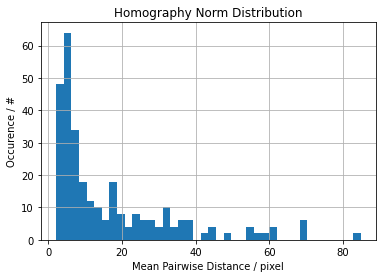

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# generate histogram of the norm of duv
log_df = pd.read_pickle('frame_to_frame_homography_regression.pkl')
log_df['duv_mpd'] = log_df.duv.apply(lambda x: np.linalg.norm(x, axis=1).mean())

hist = log_df.duv_mpd.hist(bins=40)
hist.set_title('Homography Norm Distribution')
hist.set_xlabel('Mean Pairwise Distance / pixel')
hist.set_ylabel('Occurence / #')



In [ ]:
# sample videos with supposedly little and much motion
